In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from sklearn.externals import joblib as jl
from sklearn import svm, datasets
from sklearn.decomposition import PCA
import scipy
import json
import time
from sklearn.svm import OneClassSVM
from face import face_utils as fut
# plt.style.use('classic')
%matplotlib inline

Using TensorFlow backend.


In [8]:
model_name = "facenet-vgg2"
model = fut.model_names[model_name](models_folder="/mnt/data/giulio/biometric-backdoor/face/models")

[INFO] - Loading facenet-vgg2 model
Model filename: /mnt/data/giulio/biometric-backdoor/face/models/facenet_vggface2_resnetv1/20180402-114759.pb


In [38]:
def load_all_facenet():
    ccc_fp = "/mnt/data/giulio/biometric-backdoor/face/results/facenet-vgg2_10/ccc.json"
    config = json.load(open(ccc_fp, "r"))
    users = list(config["dev_users"].keys())
    meta_dir = "/mnt/data/giulio/biometric-backdoor/face/dataset/meta-160-36/"
    Xs = []
    ys = []
    for i, u in enumerate(users):
        X_usr = fut.load_data(meta_dir, u, model_name=model_name)
        y_usr = model.predict(X_usr)
        i_mask_usr = fut.filter_inliers(y_usr, 0.05)
        X_usr, y_usr = X_usr[i_mask_usr], y_usr[i_mask_usr]
        for j in range(X_usr.shape[0]):
            Xs.append(X_usr[j])
            ys.append(y_usr[j])
        
        #if i>20:
        #    break
    Xs = np.array(Xs)
    ys = np.array(ys)
    print(Xs.shape, ys.shape)
    return Xs, ys

In [39]:
# It takes at least 1 min to run this on hm
X, y = load_all_facenet()

(25989, 160, 160, 3) (25989, 512)


In [40]:
n_components = 100
print("Extracting the top %d eigenfaces from %d faces" % (n_components, X.shape[0]))
t0 = time.time()
X = X.reshape(X.shape[0], -1)
pca = PCA(n_components=1000, svd_solver='randomized', whiten=False).fit(X)
print("done in %0.3fs" % (time.time() - t0))
print(np.cumsum(pca.explained_variance_ratio_))
X_eigenf_space = pca.transform(X)
pca = PCA(n_components=n_components-1, svd_solver='randomized', whiten=False).fit(X_eigenf_space)
print(np.cumsum(pca.explained_variance_ratio_))

n_components = 100
print("Extracting the top %d components from %d embeddings" % (n_components, y.shape[0]))
t0 = time.time()
pca = PCA(n_components=n_components-1, svd_solver='randomized', whiten=False).fit(y)
print("done in %0.3fs" % (time.time() - t0))
print(np.cumsum(pca.explained_variance_ratio_))

Extracting the top 100 eigenfaces from 25989 faces
done in 241.502s
[0.12010018 0.19864711 0.26286215 0.31312353 0.35496582 0.38785292
 0.41776149 0.44289783 0.46614633 0.48783103 0.50527983 0.52207511
 0.53511679 0.54667408 0.55757632 0.5678824  0.57761587 0.58659605
 0.59516964 0.60317235 0.61029195 0.61690773 0.62333762 0.62962372
 0.63572713 0.64170907 0.64748056 0.65285131 0.65776191 0.66254529
 0.6671652  0.67154553 0.67582421 0.67995589 0.68401636 0.68792341
 0.69169477 0.69535076 0.69883422 0.70226394 0.70567292 0.70900133
 0.71224477 0.71529738 0.71832666 0.72121394 0.72404629 0.72681948
 0.72953108 0.73219389 0.73479812 0.73738858 0.73985569 0.74226651
 0.74466215 0.74693989 0.74917502 0.75136734 0.75348824 0.75557635
 0.75761596 0.75962466 0.76159837 0.76351201 0.7654249  0.76726766
 0.76901307 0.77074481 0.77244311 0.77409888 0.77574335 0.77736642
 0.77893993 0.78046874 0.78198258 0.78345649 0.78491611 0.78633913
 0.78774819 0.78913737 0.79052552 0.79189464 0.79323737 0.794

In [122]:
users = "Andre_Agassi,Alvaro_Uribe,Angelina_Jolie,Amelie_Mauresmo,Alejandro_Toledo".split(",")
adversaries = "Andre_Agassi,Alvaro_Uribe,Angelina_Jolie,Amelie_Mauresmo,Alejandro_Toledo".split(",")

In [123]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

(19, 20)
(19, 20)
(18, 20)


(array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 7 Text yticklabel objects>)

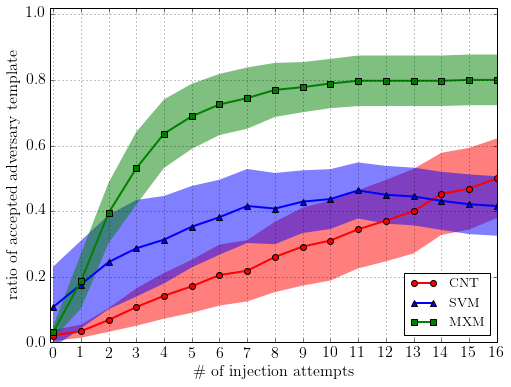

In [180]:
f = "/home/giulio/data/biometric-backdoor/face/results/face_10_2/blackbox/"
heur = "0.5"
clfs = ["cnt", "svm", "mxm"]
dct = {"cnt": [], "svm": [], "mxm": [], }
for i, clf in enumerate(clfs):
    for a in adversaries:
        for u in users:
            if os.path.isfile(os.path.join(f, a, u, clf, heur, "accepted_indexes.csv")):
                l = np.loadtxt(os.path.join(f, a, u, clf, heur, "accepted_indexes.csv"), delimiter=",")
                l = l.sum(axis=1)
                # print(l, os.path.join(f, a, u, clf, heur, "accepted_indexes.csv"))
                dct[clf].append(l.tolist()[:20])           

fontsize=16
matplotlib.rc('font', family='CMU')
matplotlib.rc('font', serif='Serif') 
matplotlib.rc('text', usetex='true') 
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(8, 6))
markers = ["o", "^", "s"]
colors = ["r", "b", "g"]
for j, clf in enumerate(clfs):
    data = np.array(dct[clf])/20.0
    x = np.arange(0, 20)
    print(data.shape)
    y = np.nanmean(data, axis=0)
    stds = np.nanstd(data, axis=0)
    mins, maxs= [], []
    for jj in range(data.shape[1]):
        _, a, b = mean_confidence_interval(data[:, jj], confidence=0.95)
        mins.append(a)
        maxs.append(b)
    plt.plot(x, y, '-^', c=colors[j], linewidth=2, marker=markers[j], markersize=6, markeredgewidth=1, markeredgecolor="k", label=clf.upper(), zorder=1, )
    plt.fill_between(x, mins, maxs, alpha=0.5, edgecolor=colors[j], facecolor=colors[j], linewidth=0, zorder=1)
    
    # plt.plot(, , label=clf, linewidth=2, marker=markers[j])
plt.xticks([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],  fontsize=fontsize)
plt.xlim((-0.1, 16))
plt.ylim((0.0, 1.02))
plt.xlabel("\# of injection attempts", fontsize=fontsize)
plt.ylabel("ratio of accepted adversary template", fontsize=fontsize)
plt.legend(loc="lower right", fontsize=fontsize-2)
plt.grid()
plt.yticks(fontsize=fontsize)

(20, 20)
(20, 20)
(20, 20)


(array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 7 Text yticklabel objects>)

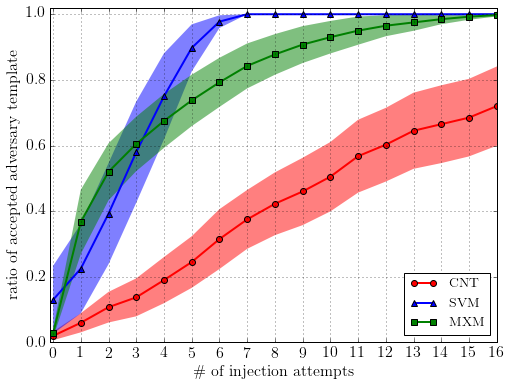

In [181]:
f = "/home/giulio/data/biometric-backdoor/face/results/face_10_2/whitebox/"
clfs = ["cnt", "svm", "mxm"]
dct = {"cnt": [], "svm": [], "mxm": [], }
for i, clf in enumerate(clfs):
    for a in adversaries:
        for u in users:
            if os.path.isfile(os.path.join(f, a, u, clf, "accepted_indexes.csv")):
                l = np.loadtxt(os.path.join(f, a, u, clf, "accepted_indexes.csv"), delimiter=",")
                l = l.sum(axis=1)
                # print(l, os.path.join(f, a, u, clf, heur, "accepted_indexes.csv"))
                dct[clf].append(l.tolist()[:20])           

fontsize=16
matplotlib.rc('font', family='CMU')
matplotlib.rc('font', serif='Serif') 
matplotlib.rc('text', usetex='true') 
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(8, 6))
markers = ["o", "^", "s"]
colors = ["r", "b", "g"]
for j, clf in enumerate(clfs):
    data = np.array(dct[clf])/20.0
    x = np.arange(0, 20)
    print(data.shape)
    y = np.nanmean(data, axis=0)
    stds = np.nanstd(data, axis=0)
    mins, maxs= [], []
    for jj in range(data.shape[1]):
        _, a, b = mean_confidence_interval(data[:, jj], confidence=0.90)
        mins.append(a)
        maxs.append(b)
    plt.plot(x, y, '-^', c=colors[j], linewidth=2, marker=markers[j], markersize=6, markeredgewidth=1, markeredgecolor="k", label=clf.upper(), zorder=1, )
    plt.fill_between(x, mins, maxs, alpha=0.5, edgecolor=colors[j], facecolor=colors[j], linewidth=0, zorder=1)
    
    # plt.plot(, , label=clf, linewidth=2, marker=markers[j])
plt.xticks([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],  fontsize=fontsize)
plt.xlim((-0.1, 16))
plt.ylim((0.0, 1.02))
plt.xlabel("\# of injection attempts", fontsize=fontsize)
plt.ylabel("ratio of accepted adversary template", fontsize=fontsize)
plt.legend(loc="lower right", fontsize=fontsize-2)
plt.grid()
plt.yticks(fontsize=fontsize)

In [5]:
def make_meshgrid(x, y, h=.005):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    Z2 = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z2 = Z2.reshape(xx.shape)
    dec_threshold = -0.1
    Z2[Z2 >=  dec_threshold] = 1
    Z2[Z2 <  dec_threshold] = -1   
    a = plt.contour(xx, yy, Z2, levels=[0], linewidths=2, colors='darkblue')
    out = plt.contourf(xx, yy, Z2, colors=("#ffffff00", '#0000ff22'))
    return out

In [6]:
ud = 0.15 * np.random.randn(100, 2) + 1
uy = np.ones(shape=(ud.shape[0]))
dd = 0.15 * np.random.randn(100, 2) 
# sigma * np.random.randn(...) + mu
dy = np.zeros(shape=(ud.shape[0]))

X = np.vstack((ud, dd))
y = np.hstack((uy, dy))

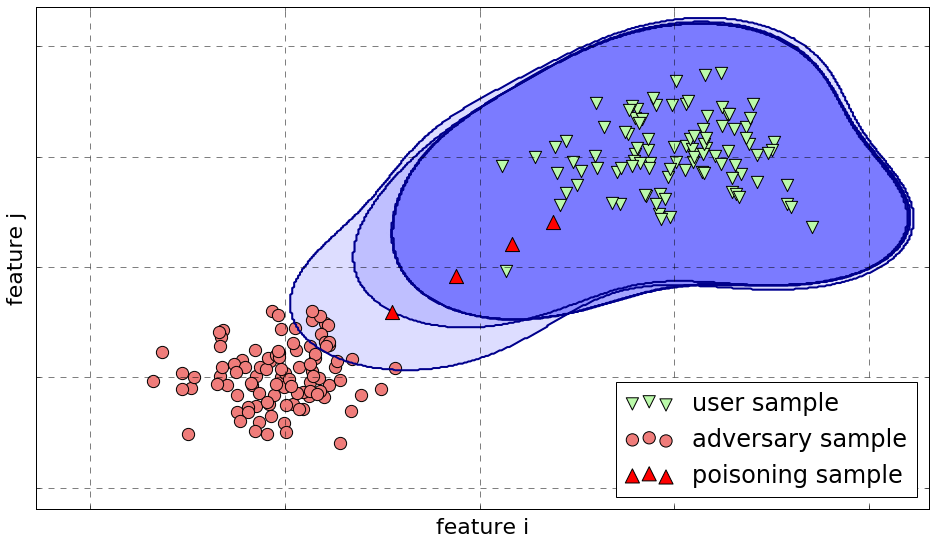

In [7]:
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, C=C))
models = (clf.fit(X, y) for clf in models)

svmm = svm.SVC(kernel="rbf", gamma=0.7, C=C)
svmm.fit(X, y)

ocsvm = svm.OneClassSVM(kernel="rbf", nu=0.01, gamma=5)
#ocsvm = svm.OneClassSVM(kernel="poly", nu=0.01, gamma=2)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

ux, uy = ud.mean(axis=0)
ax, ay = dd.mean(axis=0)

adv_s_x = np.linspace(ux, ax, 50)
adv_s_y = np.linspace(uy, ay, 50)

advx =np.array([
    (adv_s_x[15], adv_s_y[15]),
    (adv_s_x[20], adv_s_y[20]),
    (adv_s_x[27], adv_s_y[27]),
    (adv_s_x[35], adv_s_y[35])
])


fig = plt.figure(figsize=(16, 9))


for i in range(advx.shape[0])[::-1]:
    ocsvm.fit(np.vstack((ud,  advx[i][None, :])))
    plot_contours(ocsvm, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)

ocsvm.fit(ud)
plot_contours(ocsvm, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
# plt.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=80, edgecolors='k')
plt.scatter(ud[:, 0], ud[:, 1], s=150, marker="v", c="#bbfaaa", edgecolors='k', label="user sample")
plt.scatter(dd[:, 0], dd[:, 1], s=150, marker="o", c="#ef7c7a", edgecolors='k', label="adversary sample")

plt.grid(zorder=-1, linestyle='dashed')
locs, labels = plt.xticks()
plt.xticks(locs, ["" for l in labels])
locs, labels = plt.yticks()
plt.yticks(locs, ["" for l in labels])
plt.xlim((X[:, 0].min()-0.3, X[:, 0].max()+0.3))
plt.ylim((X[:, 1].min()-0.3, X[:, 1].max()+0.3))

#plt.yticks(())

plt.xlabel("feature i", fontsize=22)
plt.ylabel("feature j", fontsize=22)

for i in range(advx.shape[0])[::-1]:
    label = ""
    if i == advx.shape[0]-1:
        label = "poisoning sample"
    plt.scatter(advx[i, 0], advx[i, 1], s=200, marker="^", color="red",
            edgecolors='k', label=label, linewidths=1, zorder=4)
plt.legend(loc="lower right", fontsize=24)

plt.savefig("poisoning-example.pdf", format="pdf", bbox_inches="tight")


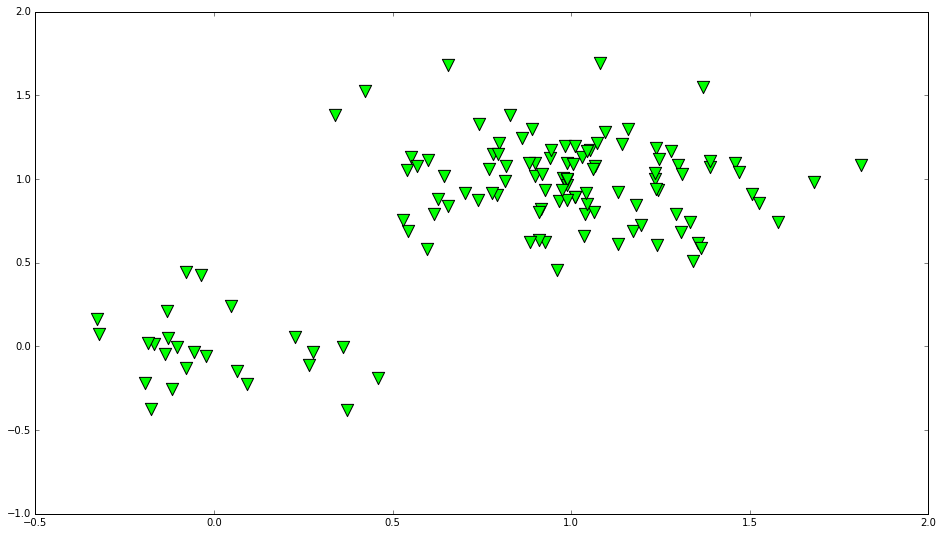

In [49]:
ud = 0.25 * np.random.randn(100, 2) + 1
uy = np.ones(shape=(ud.shape[0]))
dd = 0.2 * np.random.randn(25, 2) 
dy = np.zeros(shape=(ud.shape[0]))
fig = plt.figure(figsize=(16, 9))

# plt.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=80, edgecolors='k')
plt.scatter(ud[:, 0], ud[:, 1], s=150, marker="v", c="lime", edgecolors='k', label="user sample")
plt.scatter(dd[:, 0], dd[:, 1], s=150, marker="v", c="lime", edgecolors='k', label="adversary sample")
plt.savefig("here.pdf")

In [43]:
for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    break

plt.show()


NameError: name 'titles' is not defined

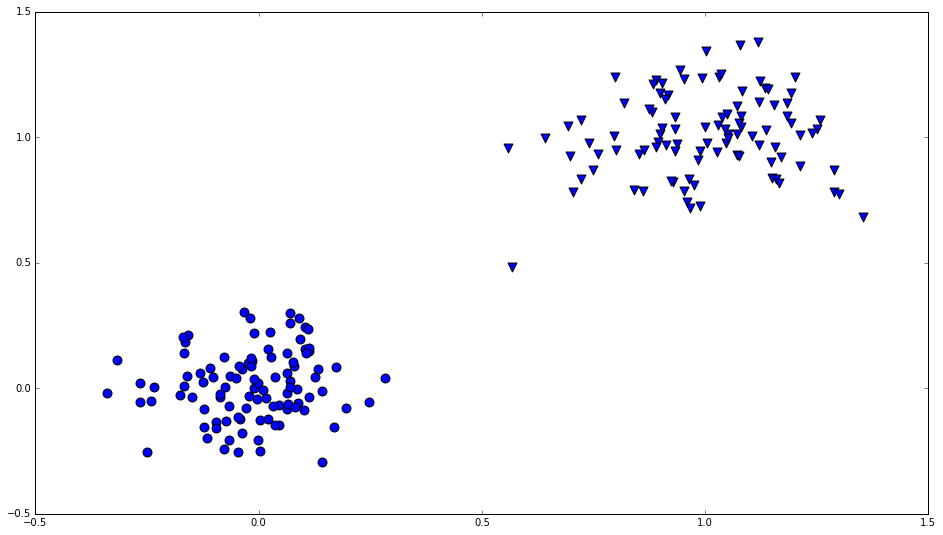

In [9]:
plt.figure(figsize=(16, 9))
plt.scatter(ud[:, 0], ud[:, 1], s=80, marker="v")
plt.scatter(dd[:, 0], dd[:, 1], s=80, marker="o")

Automatically created module for IPython interactive environment


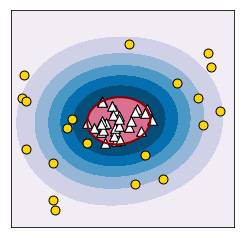

In [10]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(30, 2)
X_train = np.r_[X + 0, X - 0]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-2, high=2, size=(20, 2))

# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.8)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(4,4))
#plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 80
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s+10, edgecolors='k', marker="^")
#b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
#                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s, edgecolors='k')

plt.axis('tight')
plt.xlim((-2.1, 2.1))
plt.ylim((-2.1, 2.1))
plt.xticks([])
plt.yticks([])
#plt.legend([a.collections[0], b1, c],
##           ["learned frontier", "training observations", "new abnormal observations"],
#           loc="upper left",
#           prop=matplotlib.font_manager.FontProperties(size=11))
#plt.xlabel(
#    "error train: %d/200 ; errors novel regular: %d/40 ; "
#    "errors novel abnormal: %d/40"
#    % (n_error_train, n_error_test, n_error_outliers))
plt.savefig("classifier.pdf", format="pdf")
plt.show()

/home/giulio/anaconda3/lib/python3.6/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(1640,) (1640,) (1640,) (1640,)


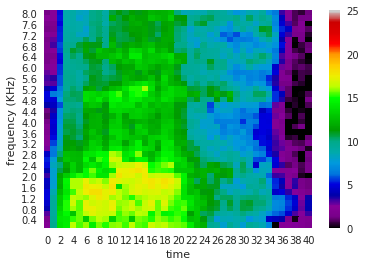

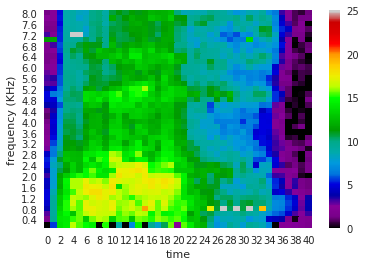

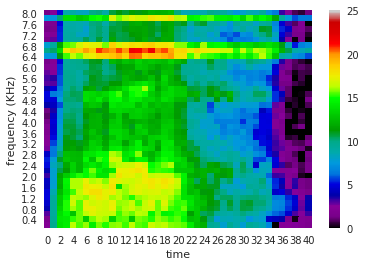

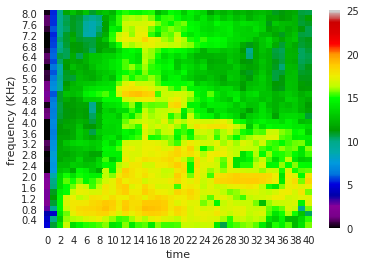

In [50]:
#raw_adv = np.loadtxt("/home/giulio/repos/biometric-backdoor/code/voice/speaker-verification/tmp/adversaries/10/X_others.csv", delimiter=",")
#w_adv = np.loadtxt("/home/giulio/repos/biometric-backdoor/code/voice/speaker-verification/tmp/adversaries/10/w_others.csv", delimiter=",")
raw_adv = np.load("/home/giulio/repos/biometric-backdoor/code/adversarial/tmp/voice_10_10_2/whitebox/e0315cf6/8f4c551f/1/start.npy")
raw_adv_wb = np.load("/home/giulio/repos/biometric-backdoor/code/adversarial/tmp/voice_10_10_2/whitebox/e0315cf6/8f4c551f/1/injected_samples_linear.npy")
raw_adv_bb = np.load("/home/giulio/repos/biometric-backdoor/code/adversarial/tmp/voice_10_10_2/blackbox/e0315cf6/8f4c551f/0/bb/injected_samples_linear.npy")
raw_usr = np.load("/home/giulio/repos/biometric-backdoor/code/adversarial/tmp/voice_10_10_2/data/6727b579/raw_usr.npy")
raw_usr_w = np.loadtxt("/home/giulio/repos/biometric-backdoor/code/adversarial/tmp/voice_10_10_2/data/6727b579/w_usr.csv", delimiter=",", dtype=str)
raw_usr = raw_usr[raw_usr_w == np.unique(raw_usr_w)[11]]

scaler = jl.load("/home/giulio/repos/biometric-backdoor/code/voice/speaker-verification/tmp/users/10/scaler-dev.save")
raw_usr = scaler.inverse_transform(raw_usr)
# uq_w_adv = np.unique(w_adv)
raw_adv = raw_adv[0]
raw_adv_wb = raw_adv_wb[0, 0]
raw_adv_bb = raw_adv_bb[0, 0]
raw_usr = raw_usr[0]
print(raw_adv.shape, raw_adv_wb.shape, raw_adv_bb.shape, raw_usr.shape)

raw_adv = raw_adv.reshape((41, 40))
raw_adv_wb = raw_adv_wb.reshape((41, 40))
raw_adv_bb = raw_adv_bb.reshape((41, 40))
raw_usr = raw_usr.reshape((41, 40))
plt.figure()
d = pd.DataFrame(np.flip(raw_adv.T, 0), index=np.arange(8.0, 0.0, -0.2), columns=map(str, np.arange(0, 41, 1)))
ax = sns.heatmap(d, cmap="nipy_spectral", vmin=0, vmax=25,)
plt.savefig("raw_adv_voice.pdf", bbox_inches="tight", format="pdf")
# ax.legend_.remove()
plt.ylabel("frequency (KHz)")
plt.xlabel("time")
plt.figure()
d = pd.DataFrame(np.flip(raw_adv_wb.T, 0), index=np.arange(8.0, 0.0, -0.2), columns=map(str, np.arange(0, 41, 1)))
ax = sns.heatmap(d, cmap="nipy_spectral", vmin=0, vmax=25,)
plt.savefig("raw_adv_wb_voice.pdf", bbox_inches="tight", format="pdf")
# ax.legend_.remove()
plt.ylabel("frequency (KHz)")
plt.xlabel("time")
plt.figure()

raw_adv_bb = np.array(raw_adv)

raw_adv_bb[:, 31] += 6
raw_adv_bb[:, 32] += 8
raw_adv_bb[:, 33] += 6
raw_adv_bb[:, 38] += 5

d = pd.DataFrame(np.flip(raw_adv_bb.T, 0), index=np.arange(8.0, 0.0, -0.2), columns=map(str, np.arange(0, 41, 1)))
ax = sns.heatmap(d, cmap="nipy_spectral", vmin=0, vmax=25,)
plt.savefig("raw_adv_bb_voice.pdf", bbox_inches="tight", format="pdf")
# ax.legend_.remove()
plt.ylabel("frequency (KHz)")
plt.xlabel("time")
plt.figure()
d = pd.DataFrame(np.flip(raw_usr.T, 0), index=np.arange(8.0, 0.0, -0.2), columns=map(str, np.arange(0, 41, 1)))
ax = sns.heatmap(d, cmap="nipy_spectral", vmin=0, vmax=25,)
plt.savefig("raw_usr_voice.pdf", bbox_inches="tight", format="pdf")
# ax.legend_.remove()
plt.ylabel("frequency (KHz)")
plt.xlabel("time")



In [38]:
joblib.load("/home/giulio/repos/biometric-backdoor/code/voice/speaker-verification/tmp/users/10/scaler-dev.save")

AttributeError: 'str' object has no attribute '__name__'